In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp drive/MyDrive/image_classification/Dataset.zip .
! unzip Dataset.zip -d Dataset/

Archive:  Dataset.zip
   creating: Dataset/Testing/
  inflating: Dataset/Testing/2015_00401.jpg  
  inflating: Dataset/Testing/2015_00402.jpg  
  inflating: Dataset/Testing/2015_00403.jpg  
  inflating: Dataset/Testing/2015_00404.jpg  
  inflating: Dataset/Testing/2015_00405.jpg  
  inflating: Dataset/Testing/2015_00406.jpg  
  inflating: Dataset/Testing/2015_00407.jpg  
  inflating: Dataset/Testing/2015_00408.jpg  
  inflating: Dataset/Testing/2015_00409.jpg  
  inflating: Dataset/Testing/2015_00410.jpg  
  inflating: Dataset/Testing/2015_00411.jpg  
  inflating: Dataset/Testing/2015_00412.jpg  
  inflating: Dataset/Testing/2015_00413.jpg  
  inflating: Dataset/Testing/2015_00414.jpg  
  inflating: Dataset/Testing/2015_00415.jpg  
  inflating: Dataset/Testing/2015_00416.jpg  
  inflating: Dataset/Testing/2015_00417.jpg  
  inflating: Dataset/Testing/2015_00418.jpg  
  inflating: Dataset/Testing/2015_00419.jpg  
  inflating: Dataset/Testing/2015_00420.jpg  
  inflating: Dataset/Testing

In [ ]:
! cp drive/MyDrive/image_classification/AI_Basic_Test.zip .
! unzip AI_Basic_Test.zip -d CSV_Datset/

Archive:  AI_Basic_Test.zip
  inflating: CSV_Datset/test_set.csv  
  inflating: CSV_Datset/train.csv    
  inflating: CSV_Datset/val.csv      


In [ ]:
import os
import pandas as pd
import torch
from torch import nn as nn
from torchvision import transforms as transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from torchvision import models
from tqdm import tqdm
import math
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
def prepare_dataset(dataset_type):
  list_class_dir = os.listdir(f"Dataset/{str(dataset_type)}")
  dataset = []
  class_dict = {folder :index for index,folder in enumerate(list_class_dir)}
  extension = set()
  for folder in list_class_dir:
    class_path = os.path.join("Dataset/Training" , folder)
    images_path = os.listdir(class_path)
    for image in images_path:
      extension.add(image.split(".")[1])
      dataset.append(dict(
          image_path = os.path.join(class_path,image),
          class_name = class_dict[folder]
      ))
  dataset = pd.DataFrame(dataset,columns=["image_path","class_name"])
  return dataset
training_dataset = prepare_dataset("Training")
validation_dataset = prepare_dataset("Validation")

In [ ]:
class ImageDataset(Dataset):
  def __init__(self,metadata,transforms = None):
    super(ImageDataset,self).__init__()
    self.metadata = metadata # load the csv file 
    self.length = self.metadata.shape[0] # return the length of data
    self.transforms = transforms # this is tranfroms the image to into tensor
  
  def __len__(self):
    return self.length
  
  def __getitem__(self,index):
    data = self.metadata.iloc[index] # based on the given index it will extract the data from metadata
    image = Image.open(data["image_path"]).convert("RGB") # reading the image
    label = data["class_name"] # reading the class
    if self.transforms != None:
      image = self.transforms(image) # transfors the image 
    label = torch.tensor(label) #convert the label into tensor
    return image , label
def get_dataloader(dataset):
  transform_list = transforms.Compose([
              transforms.ToTensor(),# convert the data into tensor
              transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), # normalize the image
              transforms.Resize((128,128)) # resize the image
  ])
  image_dataset = ImageDataset(dataset,transform_list) # prepare the image dataset
  dataloader = DataLoader(dataset = image_dataset , batch_size =32,shuffle = True) # prepare the image dataset into batch
  return dataloader
training_dataloader = get_dataloader(training_dataset) # training batch wise dataset
validation_dataloader = get_dataloader(validation_dataset) # validation batch wise dataset

In [ ]:
class ImageClassification(nn.Module):
  def __init__(self,num_class):
    super(ImageClassification,self).__init__()
    # input is (no_batch,3,128,128)
    model = models.resnet50(pretrained=True,progress=True) # resnet-50 pretrained model
    # (n_batch , 3, 1000)
    model = nn.Sequential(*(list(model.children()))[:-1]) # removing the last linear layer
    # (n_batch , 3, 2048)
    self.pretrained = model
    self.final = nn.Sequential(
        nn.Linear(2048 , 512), # (n_batch , 512)
        nn.BatchNorm1d(512), # (n_batch , 512)
        nn.Dropout(0.5), # applying of probability 0.5
        nn.ReLU(), # Applying Rectified Linear Uniit 
        # relu(x) = f(x) = max(0,x)
        nn.Linear(512 , num_class), # (n_batch , 6)
        nn.Softmax() # apply soft to get probability distribution of each sample
    ) 
    self.final_layer_weight_initialization() # 2weight initialization
  def forward(self,x):
    # x = (n_image , 3 , 256 , 256)
    x = self.pretrained(x) # (n_image , 2048 , 1 , 1)
    x = x.view(x.shape[0],x.shape[1]) # (n_image , 2048)
    x = self.final(x) # (n_image , 6)
    return x

  def final_layer_weight_initialization(self):
    for m in self.final.modules():
      if isinstance(m , nn.Linear):
        nn.init.kaiming_normal_(m.weight,1)
        nn.init.constant_(m.bias,0)
      if isinstance(m , nn.BatchNorm1d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)
        

In [ ]:
n_epochs = 5 # no of epochs
batch_size = 32 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #find the device
model = ImageClassification(6).to(device) # intializing the model
# cretaing optimizer , Adam(paremetric optimizer)
optimizer = torch.optim.Adam(params = model.parameters() , lr = 0.0001, 
                             betas = (0.9 , 0.99),weight_decay = 0.001)
loss_function = torch.nn.CrossEntropyLoss() # using Cross entropy loss function
epoch_loss = []
epoch_val_acc = []
################# Traing####################
for epoch in range(n_epochs):
  total_loss = 0.0
  for batch_idx ,(image,label) in tqdm(enumerate(training_dataloader)):
    image = image.to(device)
    label = label.to(device)
    prediction = model(image) # forward pass
    loss = loss_function(prediction , label) # calculating loss
    optimizer.zero_grad() # creating gradient from previous batch
    loss.backward() # backward pass
    optimizer.step() # updating the weight and bias
    total_loss += (loss.item() / batch_size)
    if batch_idx % 5 == 0:
      print(f"EPOCH : {epoch+1} | {n_epochs} , BATCH: {batch_idx}|{len(training_dataloader)} , loss : {total_loss / (batch_idx+1)}")
  #############claculating the validation accuracy############
  with torch.no_grad():
    count = 0
    for batch_idx ,(image,label) in tqdm(enumerate(validation_dataloader)):
      image = image.to(device)
      label = label.tolist()
      pred_prob = model(image)
      predicted_label = torch.argmax(pred_prob,dim = 1).tolist()
      for gt,pred in zip(label,predicted_label):
        if (gt == pred):
          count += 1
      if batch_idx % 5 == 0:
        print(f"EPOCH : {epoch+1} | {n_epochs} , BATCH : {batch_idx}|{len(validation_dataloader)}")
    print(f"Validation accuracy : {(count / len(validation_dataset))*100}")
    epoch_loss.append(total_loss)
    epoch_val_acc.append((count / len(validation_dataset))*100)
# # saving the model
torch.save(model.state_dict(),"drive/MyDrive/image_classification/model.pth")


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
1it [00:08,  8.04s/it]

EPOCH : 1 | 5 , BATCH: 0|45 , loss : 0.05477623641490936


6it [00:47,  7.93s/it]

EPOCH : 1 | 5 , BATCH: 5|45 , loss : 0.0553854921211799


11it [01:27,  7.89s/it]

EPOCH : 1 | 5 , BATCH: 10|45 , loss : 0.05452689968726852


16it [02:06,  7.93s/it]

EPOCH : 1 | 5 , BATCH: 15|45 , loss : 0.053672813111916184


21it [02:46,  7.86s/it]

EPOCH : 1 | 5 , BATCH: 20|45 , loss : 0.05310388689949399


26it [03:25,  7.87s/it]

EPOCH : 1 | 5 , BATCH: 25|45 , loss : 0.05225561043390861


31it [04:05,  7.90s/it]

EPOCH : 1 | 5 , BATCH: 30|45 , loss : 0.051525542812962684


36it [04:45,  8.14s/it]

EPOCH : 1 | 5 , BATCH: 35|45 , loss : 0.0510978147180544


41it [05:27,  8.18s/it]

EPOCH : 1 | 5 , BATCH: 40|45 , loss : 0.050600201436659185


45it [05:59,  7.99s/it]
1it [00:02,  2.84s/it]

EPOCH : 1 | 5 , BATCH : 0|45


6it [00:17,  2.90s/it]

EPOCH : 1 | 5 , BATCH : 5|45


11it [00:31,  2.88s/it]

EPOCH : 1 | 5 , BATCH : 10|45


16it [00:45,  2.83s/it]

EPOCH : 1 | 5 , BATCH : 15|45


21it [01:00,  2.98s/it]

EPOCH : 1 | 5 , BATCH : 20|45


26it [01:15,  2.88s/it]

EPOCH : 1 | 5 , BATCH : 25|45


31it [01:29,  2.94s/it]

EPOCH : 1 | 5 , BATCH : 30|45


36it [01:44,  2.96s/it]

EPOCH : 1 | 5 , BATCH : 35|45


41it [01:59,  2.94s/it]

EPOCH : 1 | 5 , BATCH : 40|45


45it [02:10,  2.90s/it]


Validation accuracy : 74.30555555555556


1it [00:08,  8.01s/it]

EPOCH : 2 | 5 , BATCH: 0|45 , loss : 0.04278453439474106


6it [00:47,  7.93s/it]

EPOCH : 2 | 5 , BATCH: 5|45 , loss : 0.041384742284814514


11it [01:28,  8.04s/it]

EPOCH : 2 | 5 , BATCH: 10|45 , loss : 0.04129971597682346


16it [02:07,  7.92s/it]

EPOCH : 2 | 5 , BATCH: 15|45 , loss : 0.0413324658293277


21it [02:47,  7.90s/it]

EPOCH : 2 | 5 , BATCH: 20|45 , loss : 0.04122471064329147


26it [03:27,  7.98s/it]

EPOCH : 2 | 5 , BATCH: 25|45 , loss : 0.041232995402354464


31it [04:06,  8.01s/it]

EPOCH : 2 | 5 , BATCH: 30|45 , loss : 0.0413223277897604


36it [04:46,  7.89s/it]

EPOCH : 2 | 5 , BATCH: 35|45 , loss : 0.04122232200784816


41it [05:25,  7.90s/it]

EPOCH : 2 | 5 , BATCH: 40|45 , loss : 0.0411706520471631


45it [05:57,  7.95s/it]
1it [00:03,  3.04s/it]

EPOCH : 2 | 5 , BATCH : 0|45


6it [00:17,  2.96s/it]

EPOCH : 2 | 5 , BATCH : 5|45


11it [00:32,  2.93s/it]

EPOCH : 2 | 5 , BATCH : 10|45


16it [00:46,  2.91s/it]

EPOCH : 2 | 5 , BATCH : 15|45


21it [01:01,  2.86s/it]

EPOCH : 2 | 5 , BATCH : 20|45


26it [01:16,  3.00s/it]

EPOCH : 2 | 5 , BATCH : 25|45


31it [01:30,  2.87s/it]

EPOCH : 2 | 5 , BATCH : 30|45


36it [01:44,  2.84s/it]

EPOCH : 2 | 5 , BATCH : 35|45


41it [01:58,  2.84s/it]

EPOCH : 2 | 5 , BATCH : 40|45


45it [02:10,  2.90s/it]


Validation accuracy : 88.75


1it [00:07,  7.81s/it]

EPOCH : 3 | 5 , BATCH: 0|45 , loss : 0.037026043981313705


6it [00:47,  7.94s/it]

EPOCH : 3 | 5 , BATCH: 5|45 , loss : 0.036704799781243004


11it [01:27,  8.05s/it]

EPOCH : 3 | 5 , BATCH: 10|45 , loss : 0.0371078991077163


16it [02:07,  7.98s/it]

EPOCH : 3 | 5 , BATCH: 15|45 , loss : 0.03732441505417228


21it [02:46,  7.88s/it]

EPOCH : 3 | 5 , BATCH: 20|45 , loss : 0.03729649420295443


26it [03:25,  7.86s/it]

EPOCH : 3 | 5 , BATCH: 25|45 , loss : 0.03715356066823006


31it [04:05,  7.87s/it]

EPOCH : 3 | 5 , BATCH: 30|45 , loss : 0.03711654654433651


36it [04:44,  7.84s/it]

EPOCH : 3 | 5 , BATCH: 35|45 , loss : 0.037016635139783226


41it [05:23,  7.79s/it]

EPOCH : 3 | 5 , BATCH: 40|45 , loss : 0.03708155834820212


45it [05:54,  7.89s/it]
1it [00:02,  2.75s/it]

EPOCH : 3 | 5 , BATCH : 0|45


6it [00:16,  2.79s/it]

EPOCH : 3 | 5 , BATCH : 5|45


11it [00:30,  2.79s/it]

EPOCH : 3 | 5 , BATCH : 10|45


16it [00:45,  2.82s/it]

EPOCH : 3 | 5 , BATCH : 15|45


21it [00:59,  2.85s/it]

EPOCH : 3 | 5 , BATCH : 20|45


26it [01:13,  2.89s/it]

EPOCH : 3 | 5 , BATCH : 25|45


31it [01:28,  2.87s/it]

EPOCH : 3 | 5 , BATCH : 30|45


36it [01:42,  2.92s/it]

EPOCH : 3 | 5 , BATCH : 35|45


41it [01:57,  2.91s/it]

EPOCH : 3 | 5 , BATCH : 40|45


45it [02:08,  2.87s/it]


Validation accuracy : 93.33333333333333


1it [00:07,  7.85s/it]

EPOCH : 4 | 5 , BATCH: 0|45 , loss : 0.03717843070626259


6it [00:47,  7.88s/it]

EPOCH : 4 | 5 , BATCH: 5|45 , loss : 0.035286350175738335


11it [01:26,  7.83s/it]

EPOCH : 4 | 5 , BATCH: 10|45 , loss : 0.03558601168068973


16it [02:05,  7.94s/it]

EPOCH : 4 | 5 , BATCH: 15|45 , loss : 0.03558272495865822


21it [02:45,  7.85s/it]

EPOCH : 4 | 5 , BATCH: 20|45 , loss : 0.03553565360960506


26it [03:24,  7.84s/it]

EPOCH : 4 | 5 , BATCH: 25|45 , loss : 0.03548678239950767


31it [04:03,  7.85s/it]

EPOCH : 4 | 5 , BATCH: 30|45 , loss : 0.03543519565174656


36it [04:43,  7.88s/it]

EPOCH : 4 | 5 , BATCH: 35|45 , loss : 0.035432703172167145


41it [05:22,  7.96s/it]

EPOCH : 4 | 5 , BATCH: 40|45 , loss : 0.03534529158254949


45it [05:54,  7.89s/it]
1it [00:02,  2.88s/it]

EPOCH : 4 | 5 , BATCH : 0|45


6it [00:17,  2.89s/it]

EPOCH : 4 | 5 , BATCH : 5|45


11it [00:31,  2.82s/it]

EPOCH : 4 | 5 , BATCH : 10|45


16it [00:45,  2.91s/it]

EPOCH : 4 | 5 , BATCH : 15|45


21it [01:00,  2.85s/it]

EPOCH : 4 | 5 , BATCH : 20|45


26it [01:14,  2.86s/it]

EPOCH : 4 | 5 , BATCH : 25|45


31it [01:28,  2.82s/it]

EPOCH : 4 | 5 , BATCH : 30|45


36it [01:43,  3.00s/it]

EPOCH : 4 | 5 , BATCH : 35|45


41it [01:58,  2.93s/it]

EPOCH : 4 | 5 , BATCH : 40|45


45it [02:09,  2.88s/it]


Validation accuracy : 94.93055555555556


1it [00:07,  7.84s/it]

EPOCH : 5 | 5 , BATCH: 0|45 , loss : 0.03319590911269188


6it [00:47,  7.90s/it]

EPOCH : 5 | 5 , BATCH: 5|45 , loss : 0.0345629807561636


11it [01:27,  7.94s/it]

EPOCH : 5 | 5 , BATCH: 10|45 , loss : 0.03467033193870024


16it [02:07,  8.02s/it]

EPOCH : 5 | 5 , BATCH: 15|45 , loss : 0.034722261130809784


21it [02:47,  8.06s/it]

EPOCH : 5 | 5 , BATCH: 20|45 , loss : 0.03460565209388733


26it [03:27,  8.08s/it]

EPOCH : 5 | 5 , BATCH: 25|45 , loss : 0.034593368522249736


31it [04:07,  7.99s/it]

EPOCH : 5 | 5 , BATCH: 30|45 , loss : 0.03452500328421593


36it [04:47,  8.00s/it]

EPOCH : 5 | 5 , BATCH: 35|45 , loss : 0.034612827416923314


41it [05:27,  7.87s/it]

EPOCH : 5 | 5 , BATCH: 40|45 , loss : 0.034745326947148256


45it [05:58,  7.96s/it]
1it [00:02,  2.88s/it]

EPOCH : 5 | 5 , BATCH : 0|45


6it [00:17,  2.83s/it]

EPOCH : 5 | 5 , BATCH : 5|45


11it [00:31,  2.80s/it]

EPOCH : 5 | 5 , BATCH : 10|45


16it [00:45,  2.86s/it]

EPOCH : 5 | 5 , BATCH : 15|45


21it [00:59,  2.95s/it]

EPOCH : 5 | 5 , BATCH : 20|45


26it [01:14,  2.90s/it]

EPOCH : 5 | 5 , BATCH : 25|45


31it [01:29,  3.02s/it]

EPOCH : 5 | 5 , BATCH : 30|45


36it [01:43,  2.90s/it]

EPOCH : 5 | 5 , BATCH : 35|45


41it [01:57,  2.84s/it]

EPOCH : 5 | 5 , BATCH : 40|45


45it [02:09,  2.87s/it]


Validation accuracy : 95.13888888888889


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #find the device
model = ImageClassification(6).to(device) # model initialize 
model.load_state_dict(torch.load("drive/MyDrive/image_classification/model.pth",map_location=device)) # pretrained model laod


<All keys matched successfully>

In [ ]:
class TestingDataset(Dataset):
  def __init__(self,metadata,transform):
    self.metadata = pd.read_csv(metadata)
    self.len = self.metadata.shape[0]
    self.transform = transform
  
  def __len__(self):
    return self.len
  
  def __getitem__(self,index):
    image = os.path.join("Dataset",self.metadata.iloc[index]["Image_Path"])
    image = Image.open(image).convert("RGB")
    image = self.transform(image)
    return image

transform_list = transforms.Compose([
              transforms.ToTensor(),# convert the data into tensor
              transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), # normalize the image
              transforms.Resize((128,128)) # resize the image
  ])
image_dataset = TestingDataset(metadata = "CSV_Datset/test_set.csv",transform = transform_list)
test_dataloader = DataLoader(dataset = image_dataset,batch_size = 32,shuffle = False)

In [ ]:
predict = []
with torch.no_grad():
  count = 0
  for batch_idx ,(image) in tqdm(enumerate(test_dataloader)):
    image = image.to(device)
    pred_prob = model(image) # predict probability
    predicted_label = torch.argmax(pred_prob,dim = 1).tolist() # select highest probability
    predict.extend(predicted_label)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
15it [00:58,  3.93s/it]


In [ ]:
### Load to CSV file
test_data = pd.read_csv("CSV_Datset/test_set.csv")
test_data["Class"] = predict
test_data.to_csv("Test_data.csv")

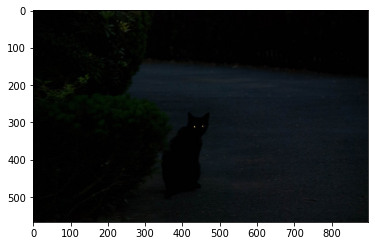

'Cat'

In [ ]:
## Showing the result for testing data
list_class_dir = os.listdir(f"Dataset/Training")
dataset = []
class_dict = {index :folder for index,folder in enumerate(list_class_dir)}
index = 5
image_path = os.path.join("Dataset",test_data.iloc[index]["Image_Path"])
image = np.array(Image.open(image_path))
plt.imshow(image)
plt.show()
class_dict[int(test_data.iloc[index]["Class"])]